# ✅ Cell 1 — Project Initialization and Library Imports

In [ ]:
# ==========================================
# 1. CORE SYSTEM & FILE MANAGEMENT
# ==========================================
import os          # Interaction with the operating system (folders, environment)
import shutil      # Advanced file operations (copying, moving, deleting directories)
from pathlib import Path  # Modern, object-oriented file path manipulation

# ==========================================
# 2. DATA PROCESSING & STRING MATCHING
# ==========================================
import re          # Pattern matching and text cleaning using Regular Expressions
import pandas as pd  # Data structures (DataFrames) for managing labels and metadata

# ==========================================
# 3. COMPUTER VISION & NUMERICAL COMPUTING
# ==========================================
import cv2         # OpenCV library for image loading, resizing, and filtering
import numpy as np  # Matrix operations and handling image data as numerical arrays

# ✅ Cell 2 — Load and Validate Haar Cascade Classifiers

In [ ]:
# --- Configuration: Define File Paths ---
# Using raw strings (r"") to handle backslashes in Windows paths correctly
FACE_XML_PATH = r"E:\Facial_Recognition_Project\openCV_Haar_Casscade\haarcascade_frontalface_default.xml"
EYE_XML_PATH  = r"E:\Facial_Recognition_Project\openCV_Haar_Casscade\haarcascade_eye.xml"

# --- Initialization: Load Classifiers ---
# Initializing the Haar Cascade classifier for face detection
face_cascade = cv2.CascadeClassifier(FACE_XML_PATH)

# Initializing the Haar Cascade classifier for eye detection
eye_cascade  = cv2.CascadeClassifier(EYE_XML_PATH)

# --- Validation: Path Integrity Checks ---
# Ensure the face XML file was found and loaded; otherwise, stop execution
if face_cascade.empty():
    raise FileNotFoundError(f"Face cascade not loaded. Check: {FACE_XML_PATH}")

# Ensure the eye XML file was found and loaded; otherwise, stop execution
if eye_cascade.empty():
    raise FileNotFoundError(f"Eye cascade not loaded. Check: {EYE_XML_PATH}")

# ✅ Cell 3 —  Face and Eye Detection Preprocessing

### crop function (name says 2 eyes → enforce 2)

In [ ]:
def get_cropped_image_if_2_eyes(image_path: str, min_eyes: int = 2):
    """
    Detects a face in an image and returns a cropped version only if a 
    minimum number of eyes are also detected within the face area.
    """
    # Load the image from the specified file path
    img = cv2.imread(image_path)
    
    # Validation: Ensure the image was successfully read from the disk
    if img is None:
        print(f"Error: Image not loaded. Check path: {image_path}")
        return None

    # Convert the image to grayscale to improve detection performance
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Detect faces using the pre-loaded Haar Cascade classifier
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    # Iterate through every face found in the image
    for (x, y, w, h) in faces:
        # Define the Region of Interest (ROI) for both grayscale and color versions
        roi_gray  = gray[y:y+h, x:x+w]  # Used for detecting eyes
        roi_color = img[y:y+h, x:x+w]   # Used for the final cropped output
        
        # Detect eyes specifically within the boundaries of the detected face
        eyes = eye_cascade.detectMultiScale(roi_gray, scaleFactor=1.1, minNeighbors=7)

        # Logical Check: Only return the face crop if it contains enough eyes
        if len(eyes) >= min_eyes:
            return roi_color

    # Return None if no face with the required number of eyes was found
    return None

# ✅ Cell 4 — scan data folders + recreate cropped folder

In [ ]:
# --- Path Configuration ---
# Define the source directory containing raw celebrity images
path_to_data = Path(r"E:\Facial_Recognition_Project\data")

# Define the destination directory where processed/cropped images will be saved
path_to_cropped_data = Path(r"E:\Facial_Recognition_Project\cropped_data")

# --- Directory Cleanup & Creation ---
# If the cropped data folder already exists, delete it and all its contents to start fresh
if path_to_cropped_data.exists():
    shutil.rmtree(path_to_cropped_data)

# Create the cropped data directory; 'parents=True' creates mid-level folders if missing
path_to_cropped_data.mkdir(parents=True, exist_ok=True)

# --- Subdirectory Discovery ---
# Identify all subfolders (celebrity names) within the raw data path and sort them alphabetically
image_directories = sorted([p for p in path_to_data.iterdir() if p.is_dir()])

# Provide visual confirmation of how many classes/celebrities were identified
print("Found celebrity folders:", len(image_directories))


Found celebrity folders: 105


# ✅ Cell 5 — crop images and build celebrity_file_names correctly

In [ ]:
# --- Helper Function: String Formatting ---
def folder_to_excel_name(folder_name: str) -> str:
    """Cleans folder names by removing prefixes and replacing underscores with spaces."""
    name = folder_name
    # Remove the 'pins_' prefix if it exists in the folder name
    if name.startswith("pins_"):
        name = name[len("pins_"):]
    # Replace underscores with spaces and remove any leading/trailing whitespace
    name = name.replace("_", " ").strip()
    return name

# --- Initialization ---
celebrity_file_names = {}  # Dictionary to map 'Clean Name' to list of [saved_paths]
valid_ext = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}  # Set of allowed image formats

# --- Main Processing Loop ---
for celeb_dir in image_directories:
    celeb_folder = celeb_dir.name                    # Get original folder name (e.g., pins_Adriana_Lima)
    celeb_name   = folder_to_excel_name(celeb_folder)  # Get cleaned name (e.g., Adriana Lima)

    # Initialize the dictionary key with an empty list if it doesn't exist
    celebrity_file_names.setdefault(celeb_name, [])
    
    # Create a matching subdirectory in the cropped_data folder
    cropped_folder = path_to_cropped_data / celeb_folder
    cropped_folder.mkdir(parents=True, exist_ok=True)

    count = 1  # Reset counter for each celebrity to name files sequentially
    
    # Iterate through all files in the current celebrity's directory
    for img_path in sorted(celeb_dir.iterdir()):
        # Skip directories or files that do not match the valid image extensions
        if not img_path.is_file() or img_path.suffix.lower() not in valid_ext:
            continue

        # Call the detection function; returns cropped image if 2 eyes are found
        roi = get_cropped_image_if_2_eyes(str(img_path))
        
        # If no valid face/eyes detected, skip to the next image
        if roi is None:
            continue

        # Define the output filename with leading zeros (e.g., pins_Adriana_Lima_0001.jpg)
        out_name = f"{celeb_folder}_{count:04d}.jpg"
        out_path = cropped_folder / out_name
        
        # Save the processed (cropped) image to the disk
        cv2.imwrite(str(out_path), roi)

        # Store the path in our dictionary for future use (e.g., creating a CSV/Excel)
        celebrity_file_names[celeb_name].append(str(out_path))
        count += 1

# --- Final Status ---
print("Celebrities with cropped images processed:", len(celebrity_file_names))

Celebrities with cropped images: 105


# ✅ Cell 6 — read Excel and build a robust label map (NO indexing by count)

In [ ]:
# --- Load Excel Metadata ---
# Define path to the source Excel file containing celebrity names and approval status
excel_file_path = Path(r"E:\Facial_Recognition_Project\dataset.xlsx")
df = pd.read_excel(excel_file_path)

# --- Define Normalization Logic ---
def norm_name(s: str) -> str:
    """Standardizes strings: lowercase, removes underscores, and collapses extra spaces."""
    s = str(s).strip().lower().replace("_", " ")  # Basic cleaning
    s = re.sub(r"\s+", " ", s)                   # Replace multiple spaces with a single space
    return s

# --- Process DataFrame Columns ---
# Create a normalized name column for consistent lookups
df["name_norm"] = df["Name"].apply(norm_name)
# Clean the status column to ensure strings like ' Approved ' become 'approved'
df["status_norm"] = df["Status"].astype(str).str.strip().str.lower()

# --- Label Encoding ---
# Map human-readable status to machine-readable integers (Approved=1, Denied=0)
label_map = {"approved": 1, "denied": 0}
df["label"] = df["status_norm"].map(label_map)

# --- Validation: Check for Invalid Labels ---
# Stop execution if there are status values in the Excel that don't match our map
if df["label"].isna().any():
    bad = df[df["label"].isna()][["Name", "Status"]]
    raise ValueError(f"Found unknown Status values in Excel:\n{bad}")

# Create a lookup dictionary mapping normalized names to their binary labels
name_to_label = dict(zip(df["name_norm"], df["label"]))

# --- Alignment: Match Folders to Excel Records ---
class_directory = {} # Stores final valid mapping
missing = []         # Tracks folders that don't have an entry in the Excel

for celeb_name in celebrity_file_names.keys():
    k = norm_name(celeb_name)  # Normalize folder name for comparison
    if k not in name_to_label:
        missing.append(celeb_name)
        continue
    # Store the final label as an integer
    class_directory[celeb_name] = int(name_to_label[k])

# --- Reporting: Show Missing Matches ---
if missing:
    print("WARNING: These celebrities exist in folders but not matched in Excel (check spelling):")
    for m in missing[:20]:  # Show first 20 to avoid cluttering the console
        print(" -", m)
    print("Total missing:", len(missing))

# --- Final Cleanup ---
# Remove images from our dictionary if the celebrity isn't found in the Excel 'Approved' list
celebrity_file_names = {k: v for k, v in celebrity_file_names.items() if k in class_directory}

print("After filtering, celebrities used:", len(celebrity_file_names))

After filtering, celebrities used: 105


# ✅ Cell 7 — build X and y

In [ ]:
import pywt  # Import PyWavelets for discrete wavelet transforms

# --- Wavelet Transformation Helper ---
def w2d(image, mode="haar", level=1):
    """
    Performs 2D Wavelet Transformation to extract high-frequency features (edges/textures).
    """
    # Convert image to grayscale for transform analysis
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Normalize pixel values to a 0.0 - 1.0 float range
    gray = np.float32(gray) / 255.0

    # Decompose the image into wavelet coefficients
    coeffs = pywt.wavedec2(gray, mode, level=level)
    coeffs = list(coeffs)
    
    # Zero out the 'Approximation' (low-frequency) component to isolate details/edges
    coeffs[0] *= 0 

    # Reconstruct the image using only the detail coefficients
    recon = pywt.waverec2(coeffs, mode)
    
    # Rescale back to 0-255 range and convert to unsigned 8-bit integer
    recon = np.uint8(np.clip(recon * 255, 0, 255))
    return recon

# --- Feature Vector Assembly ---
X, y = [], []  # X = Feature vectors, y = Labels

# Loop through the filtered celebrity dictionary
for celeb_name, files in celebrity_file_names.items():
    label = class_directory[celeb_name]  # Retrieve the 0/1 label assigned from Excel

    for fp in files:
        img = cv2.imread(fp) # Load the cropped face image
        if img is None:
            continue

        # 1. Prepare Raw Feature: Resize to 32x32 and keep 3 color channels (RGB)
        raw32 = cv2.resize(img, (32, 32))
        
        # 2. Prepare Wavelet Feature: Use Daubechies (db1) transform at level 5
        wav = w2d(img, "db1", 5)
        wav32 = cv2.resize(wav, (32, 32))

        # 3. Stack Features: Combine Raw (32*32*3) and Wavelet (32*32*1) into one long vector
        feat = np.vstack((
            raw32.reshape(32*32*3, 1), # Flat color pixel data
            wav32.reshape(32*32,   1)  # Flat texture/edge data
        )).reshape(-1) # Flatten into a 1D array

        X.append(feat) # Add the feature vector to the dataset
        y.append(label) # Add the corresponding label

# --- Final Conversion to NumPy ---
X = np.array(X, dtype=np.float32)  # Convert features to a 2D float32 matrix
y = np.array(y, dtype=np.int64)    # Convert labels to a 1D int64 vector

# --- Summary Statistics ---
print("X shape:", X.shape) # Total samples vs. total features per sample
print("Approved:", int(y.sum()), "Denied:", int((y == 0).sum()))

X shape: (8638, 4096)
Approved: 3933 Denied: 4705


# ✅ Cell 8 — split first, THEN scale (no leakage)

In [ ]:
# --- Import Scikit-Learn Utilities ---
from sklearn.model_selection import train_test_split  # Utility to split data into training and testing sets
from sklearn.preprocessing import StandardScaler      # Utility to normalize features to zero mean and unit variance

# --- Dataset Splitting ---
# We split the data: 80% for training the model and 20% for testing its performance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,       # Reserve 20% of data for the test set
    stratify=y,          # Maintain the same ratio of Approved/Denied in both sets
    shuffle=True,        # Randomize the order of data before splitting
    random_state=6       # Set a seed for reproducibility (results will be the same every run)
)

# --- Feature Scaling (Standardization) ---
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data ONLY and transform it
# This calculates the mean and standard deviation for each feature
X_train = scaler.fit_transform(X_train)

# Transform the test data using the parameters (mean/std) from the training set
# This prevents 'data leakage' from the test set into the training process
X_test  = scaler.transform(X_test)

# --- Final Verification ---
# Print the final dimensions of the matrices to ensure they are ready for modeling
print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("y_train:", y_train.shape, "y_test:", y_test.shape)

X_train: (6910, 4096) X_test: (1728, 4096)
y_train: (6910,) y_test: (1728,)


# Cell 9- Model Selection, Hyperparameter Tuning, and Evaluation

In [14]:
# --- Import Scikit-Learn Pipeline and SVM Components ---
from sklearn.pipeline import Pipeline             # Groups scaling and model into a single object
from sklearn.preprocessing import StandardScaler   # Normalizes features (mean=0, variance=1)
from sklearn.svm import SVC                        # Support Vector Classifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV # Cross-validation and tuning
from sklearn.metrics import classification_report, confusion_matrix # Performance analytics

# --- Pipeline Construction ---
# We wrap the scaler and classifier together to prevent data leakage during cross-validation
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="rbf", class_weight="balanced")) # 'balanced' handles uneven class distributions
])

# --- Hyperparameter Tuning Strategy ---
# Define a range of C (regularization) and Gamma (kernel coefficient) to test
param_grid = {
    "clf__C":     [1, 3, 10, 30, 100],      # Controls the tradeoff between error and decision boundary
    "clf__gamma": ["scale", 1e-3, 3e-3, 1e-2] # Defines how far the influence of a single training example reaches
}

# Define cross-validation splits (5-fold) ensuring class ratios remain consistent
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the Grid Search to find the best combination of parameters
grid = GridSearchCV(
    pipe,
    param_grid=param_grid,
    cv=cv,
    n_jobs=-1,      # Use all available CPU cores for faster computation
    scoring="f1"    # Optimizing for F1-score (balance between Precision and Recall)
)

# --- Training / Optimization ---
grid.fit(X_train, y_train)

# --- Display Results ---
print("Best params:", grid.best_params_)
print("Best CV F1 Score:", grid.best_score_)

# --- Final Evaluation on Unseen Test Data ---
best_model = grid.best_estimator_ # Extract the best-performing model
y_pred = best_model.predict(X_test) # Predict labels for the held-out test set

# Output performance metrics
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nDetailed Classification Report:\n", classification_report(y_test, y_pred, digits=4))

Best params: {'clf__C': 3, 'clf__gamma': 'scale'}
Best CV F1: 0.5855826090693319

Confusion matrix:
 [[624 317]
 [332 455]]

Report:
               precision    recall  f1-score   support

           0     0.6527    0.6631    0.6579       941
           1     0.5894    0.5781    0.5837       787

    accuracy                         0.6244      1728
   macro avg     0.6210    0.6206    0.6208      1728
weighted avg     0.6239    0.6244    0.6241      1728



# visualize the confusion matrix

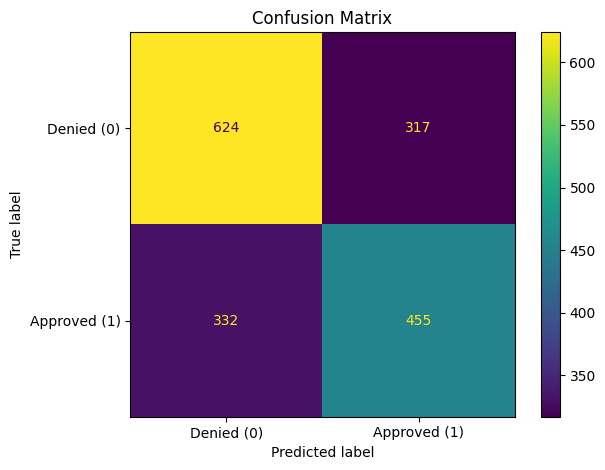

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# If you already have y_test and y_pred:
# y_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Denied (0)", "Approved (1)"])
disp.plot(values_format="d")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


# Cell 10- Save the trained baseline model correctly

In [15]:
# --- Import Serialization Library ---
import joblib  # Efficient library for saving/loading large NumPy-based Python objects

# --- Save the Final Pipeline ---
# Because we used a Pipeline, 'best_model' contains both the scaling logic and the SVM weights.
# This ensures that when you load the model later, the new data is scaled exactly like the training data.
joblib.dump(best_model, "svm_baseline.joblib") 

# --- Reference: Manual Saving (If not using Pipeline) ---
# If you had handled scaling and classification separately, you would need to save both:
# joblib.dump(scaler, "scaler.joblib")  # Save the normalization parameters
# joblib.dump(clf, "svm.joblib")         # Save the mathematical model

['svm_baseline.joblib']

#  Cell 11- Saving Test Datasets as NumPy Arrays

In [16]:
import numpy as np # Import NumPy for high-performance array storage

# --- Saving the Feature Matrix ---
# Stores the processed, scaled feature vectors for the test set
# .npy is a binary format that preserves the exact data types and shapes
np.save("X_test.npy", X_test)

# --- Saving the Target Labels ---
# Stores the ground-truth labels (0 or 1) corresponding to X_test
np.save("y_test.npy", y_test)